In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats as sps
import scipy.optimize as spo

import math
from collections import namedtuple
from functools import partial

In [2]:
data = pd.read_csv("chips.txt", header = None)

X = data.values[:,:2]
X[:, 0] = X[:, 0]
Y = data.values[:,2]

eps = 1e-8

np.random.seed(0)
block_n = 10
permutation = np.random.permutation(len(X))

x_parts = np.array_split(X[permutation], block_n)
y_parts = np.array_split(Y[permutation], block_n)

In [3]:
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

Params = namedtuple("Params", "k norm trans kernel")

In [4]:
step = 0.01
x_min, y_min = np.amin(X, axis = 0) - step
x_max, y_max = np.amax(X, axis = 0) + step

In [5]:
class knnClassifier():

    def __init__(self, params):
        self.params = params
        
    def fit(self, x, y):
        self.x = self.params.trans(x)
        self.y = y
        
    def predict(self, points):
        points = self.params.trans(points)
        ans = []
        for point in points:
            distances = self.params.norm(self.x - point, axis = -1)
            dist_arg_sorted = np.argsort(distances)
            norm_distance = distances[dist_arg_sorted[self.params.k + 1]]

            ys = np.unique(self.y)
            scores = [np.sum(self.params.kernel(distances / norm_distance) * (self.y == y))
                      for y in ys]
            ans.append(ys[np.argmax(scores)])
        return np.array(ans)

In [6]:
def safeDiv(a, b):
    if (b == 0):
        return 0
    return a / b

def precision(contingency_table):
    return safeDiv(contingency_table[1][1], (contingency_table[1][1] + contingency_table[0][1]))

def recall(contingency_table):
    return safeDiv(contingency_table[1][1], (contingency_table[1][1] + contingency_table[0][0]))

def fallout(contingency_table):
    return safeDiv(contingency_table[0][1], (contingency_table[0][1] + contingency_table[1][0]))

def f1_measure(contingency_table):
    p = precision(contingency_table)
    r = recall(contingency_table)
    return safeDiv(2 * p * r, (p + r))

def f1_measure_reversed(contingency_table):
    ct = np.array(contingency_table)
    for i in [0, 1]:
        ct[i][0], ct[i][1] = ct[i][1], ct[i][0]
    return f1_measure(ct)


f1_measure_vec = np.vectorize(f1_measure, signature="(2,2)->()")
f1_measure_reversed_vec = np.vectorize(f1_measure_reversed, signature="(2,2)->()")

def cross_validate_vec(x_parts, y_parts, classifier, cl=1):
    cts = []
    for i in range(len(x_parts)):
        x_train = np.concatenate(np.delete(x_parts, i, 0))
        y_train = np.concatenate(np.delete(y_parts, i, 0))
        x_test = x_parts[i]
        y_test = y_parts[i]
        
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)

        true_positive  = np.sum(np.logical_and(y_pred == cl, y_test == cl))
        false_positive = np.sum(np.logical_and(y_pred == cl, y_test != cl))
        true_negative  = np.sum(np.logical_and(y_pred != cl, y_test != cl))
        false_negative = np.sum(np.logical_and(y_pred != cl, y_test == cl))

        contingency_table = [[0, 0], [0, 0]]
        contingency_table[1][1] = true_positive  / y_test.shape[0]
        contingency_table[0][1] = false_positive / y_test.shape[0]
        contingency_table[1][0] = true_negative  / y_test.shape[0]
        contingency_table[0][0] = false_negative / y_test.shape[0]
        cts.append(contingency_table)
    
    return np.array(cts)

def cross_validate(x_parts, y_parts, classifier, cl=1):
    return np.average(cross_validate_vec(x_parts, y_parts, classifier, cl), axis = 0)

In [7]:
def wilcoxon(x, y):
    d = x - y
    d = np.compress(np.not_equal(d, 0), d, axis=-1)
    count = len(d)
    
    r = sps.rankdata(np.abs(d))
    r_plus  = np.sum((d > 0) * r, axis = 0)
    r_minus = np.sum((d < 0) * r, axis = 0)
    
    T = min(r_plus, r_minus)
    return T
    

In [8]:
def identity(x):
    return x

def polar(x):
    return np.column_stack([
        np.sqrt(x[:,0] ** 2 + x[:,1] ** 2),
        np.arctan2(x[:,1], x[:,0])
    ])

def withPolar(x):
    return np.concatenate([x, polar(x)], axis = 1)

def withRadius(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        np.sqrt(x[:,0] ** 2 + x[:,1] ** 2)
    ])

def withSqr(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        x[:,0] ** 2,
        x[:,1] ** 2,
        x[:,0] * x[:,1]
    ])

def with3(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        x[:,0] ** 3,
        x[:,0] ** 2 * x[:,1],
        x[:,0] * x[:,1] ** 2,
        x[:,1] ** 3
    ])


def kernelConst(x):
    return (np.abs(x) < 1.0) * 0.5

def kernelTriangle(x):
    xabs = np.abs(x)
    return (xabs < 1.0) * (1.0 - xabs)

def kernelEpanechnikov(x):
    return 0.75 * (1.0 - x ** 2.0) * (np.abs(x) < 1.0)


knn_params = [
    Params(k, partial(np.linalg.norm, ord = norm_ord), trans_f, kernel_f)
    for k in np.arange(2, round(math.sqrt(len(X)) + 1))
    for norm_ord in [
        1,
        1.5,
        2
    ]
    for trans_f in [
        identity,
        withSqr,
        withRadius,
        with3
    ]
    # Parzen-Rosenblatt window with variable window width
    for kernel_f in [
        kernelConst,
        kernelTriangle,
        kernelEpanechnikov
    ]
]

In [9]:
# f1_measure_vec = np.vectorize(f1_measure, signature="(2,2)->()")
# f1_0 = f1_measure_vec(cross_validate_vec(x_parts, y_parts, knnClassifier(params_set[0])))
# f1_1 = f1_measure_vec(cross_validate_vec(x_parts, y_parts, knnClassifier(params_set[1])))

# print(f1_0)
# print(f1_1)

# print(wilcoxon(f1_0, f1_1))

In [10]:
knn_cts = [cross_validate(x_parts, y_parts, knnClassifier(p))
                     for p in knn_params]
print(knn_cts)

[array([[ 0.11893939,  0.12954545],
       [ 0.38106061,  0.37045455]]), array([[ 0.12727273,  0.15606061],
       [ 0.35454545,  0.36212121]]), array([[ 0.12727273,  0.15606061],
       [ 0.35454545,  0.36212121]]), array([[ 0.07575758,  0.22878788],
       [ 0.28181818,  0.41363636]]), array([[ 0.07575758,  0.21212121],
       [ 0.29848485,  0.41363636]]), array([[ 0.07575758,  0.21212121],
       [ 0.29848485,  0.41363636]]), array([[ 0.07575758,  0.22045455],
       [ 0.29015152,  0.41363636]]), array([[ 0.07575758,  0.21287879],
       [ 0.29772727,  0.41363636]]), array([[ 0.08409091,  0.22121212],
       [ 0.28939394,  0.40530303]]), array([[ 0.075     ,  0.22878788],
       [ 0.28181818,  0.41439394]]), array([[ 0.07575758,  0.21287879],
       [ 0.29772727,  0.41363636]]), array([[ 0.07575758,  0.22121212],
       [ 0.28939394,  0.41363636]]), array([[ 0.09242424,  0.12121212],
       [ 0.38939394,  0.3969697 ]]), array([[ 0.15227273,  0.17272727],
       [ 0.33787879,  0.3371

In [11]:
f1  = np.max([f1_measure(ct) for ct in knn_cts])
f1r = np.max([f1_measure_reversed(ct) for ct in knn_cts])
print(f1, f1r)

knn_best_index = np.argmax([f1_measure(ct) for ct in knn_cts])
knn_best_param = knn_params[knn_best_index]
knn_best_ct    = knn_cts[knn_best_index]    

print(knn_best_param)

0.805116629044 0.802440884821
Params(k=11, norm=functools.partial(<function norm at 0x7f44bb53b048>, ord=1), trans=<function identity at 0x7f44a3e4a8c8>, kernel=<function kernelTriangle at 0x7f44a3b07b70>)


In [12]:
class Demonstrator():
    
    def __init__(self, x_min, y_min, x_max, y_max, step, classifier):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.step = step
        self.classifier = classifier
        
    def prepare(self, x, y):
        self.x = x
        self.y = y
        
        xx, yy = np.meshgrid(np.arange(self.x_min, self.x_max, self.step),
                             np.arange(self.y_min, self.y_max, self.step))
        self.xx = xx
        self.yy = yy

        self.classifier.fit(x, y)
        points = np.column_stack([self.xx.reshape((-1)), self.yy.reshape((-1))])
        self.zz = np.array([self.classifier.predict([p]) for p in points]).reshape(xx.shape)

    def plot(self):
        plt.figure(figsize=(15, 15))
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)

        x0, y0 = self.x[self.y == 0].T
        x1, y1 = self.x[self.y == 1].T

        plt.pcolormesh(self.xx, self.yy, self.zz, cmap = cmap_light)
        plt.scatter(x0, y0, marker = 'D', color = 'red',  s = 50)
        plt.scatter(x1, y1, marker = 'o', color = 'blue', s = 50)
        plt.show()

In [13]:
d = Demonstrator(x_min, y_min, x_max, y_max, step, knnClassifier(knn_best_param))
d.prepare(X, Y)

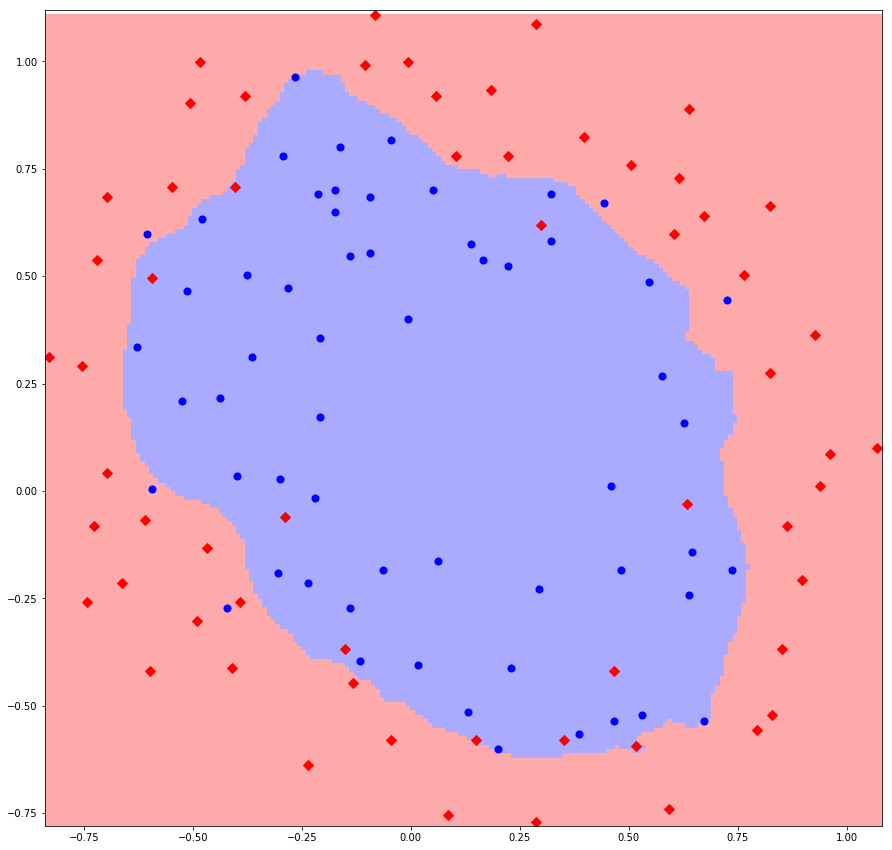

In [14]:
d.plot()

In [15]:
class svnClassifier():

    def __init__(self, kernel, c):
        self.kernel = kernel
        self.c = c
    
    def kernel_vec(self, point):
        return np.apply_along_axis(lambda x_i: self.kernel(x_i, point), 1, self.x)
    
    def fit(self, x, y):
        l = len(x)
        y = y * 2 - 1
        
        q_generator = lambda i, j : y[i] * y[j] * self.kernel(x[i], x[j])
        q = np.fromfunction(np.vectorize(q_generator), (l, l), dtype=int)
        l_ones = np.ones(l)

        L = lambda x : x.dot(q).dot(x) / 2 - np.dot(l_ones, x)
        constr = [ { "type": "eq",   "fun": lambda x: np.dot(y, x)        }
                 , { "type": "ineq", "fun": lambda x: x                   }
                 , { "type": "ineq", "fun": lambda x: self.c * l_ones - x } ]
#         grad = lambda x: np.dot(x.T, q) - l_ones   jac = grad,

        opt = spo.minimize(L, np.random.randn(l), constraints = constr)
        
        self.l_y = opt.x * y
        self.x   = x
        
        support_indices = np.nonzero(np.logical_and(opt.x > eps, opt.x < self.c - eps))[0]
        print(support_indices, opt.x[support_indices])
        self.w_0 = 0
        if (len(support_indices) > 0):
            sv_index = support_indices[0]
            self.w_0 = np.dot(self.l_y, self.kernel_vec(x[sv_index])) - y[sv_index]

#         print(np.average(np.vectorize(lambda i : self.kernel(self.w, x[i]) - y[i])(np.nonzero(self.w)[0])))
#         self.w_0 = np.average(np.vectorize(lambda i : self.kernel(self.w, x[i]) - y[i])(np.nonzero(self.w)[0]))
        
    def predict(self, points):
        ans = []
        for point in points:
            ans.append((np.sign(np.dot(self.l_y, self.kernel_vec(point)) - self.w_0) + 1) / 2)
        return ans

In [16]:
def kern(x, y):
#     return 2.7182818284590452354 ** (- (np.linalg.norm(x - y) ** 2) * 22)
    return np.dot(x, y)  + (np.linalg.norm(x) ** 2) * (np.linalg.norm(y) ** 2)
k = 1
d = Demonstrator(x_min * k, y_min * k, x_max * k, y_max * k, step * k, svnClassifier(kern, 10))
d.prepare(X, Y)

[  1  44  69 111] [ 4.1407821   5.0271156   3.95010477  5.21779293]


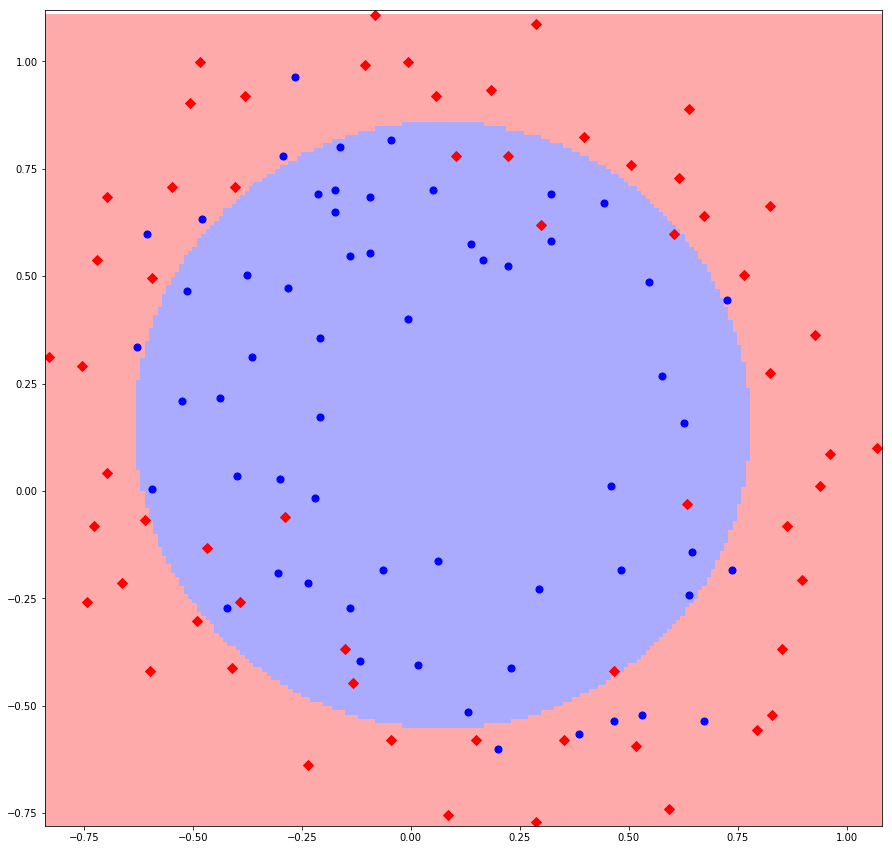

In [17]:
d.plot()

In [18]:
svn_params = [c for c in range(10)]

In [19]:
svn_cts = [cross_validate(x_parts, y_parts, svnClassifier(kern, c)) for c in svn_params]

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[ 7 28 89 96] [ 0.56276246  0.34903649  0.79800702  0.70980597]
[ 6 10 11 74 94] [ 0.55581625  0.53654198  0.50581123  0.22476591  0.36178109]
[ 4  9 11] [ 0.15086944  0.62854857  0.22058199]
[ 2  9 10] [ 0.50834548  0.60634262  0.1146881 ]
[ 9 10 11 36] [ 0.6737666   0.47213932  0.50364069  0.70526797]
[  2  11  36 102] [ 0.04953836  0.04612526  0.44486263  0.34919901]
[11 67 74 89] [ 0.95845405  0.03472214  0.58931595  0.48695214]
[  2  18  69  89 102] [ 0.80578228  0.16228456  0.74211111  0.40507329  0.36897098]
[ 9 29 57 87] [ 0.13527689  0.82659186  0.25190939  0.29004064]
[  6 101] [ 0.52464228  0.52464228]
[ 17  57  89 100] [ 0.46585087  1.05246757  0.50131308  0.08530362]
[  0  63  89 105] [ 0.21041482  1.55396147  0.69438959  0.45876588]
[ 0  2  9 57] [ 1.86509469  0.62859072  0.34233718  0.8360226 ]
[ 0 43 74] [ 1.73692958  0.23535655  0.49842698]
[  0   9  57 100] [ 1.19035525  1.44159185  1.58194823  0.95000113]
[ 

In [23]:
f1  = np.max(f1_measure_vec(svn_cts))
f1r = np.max(f1_measure_reversed_vec(svn_cts))
print(f1, f1r)

svn_best_index = np.argmax([f1_measure_reversed(ct) for ct in svn_cts])
svn_best_param = svn_params[svn_best_index]
svn_best_ct    = svn_cts[svn_best_index]    

print(svn_best_param)
print(svn_cts)

0 0.676028084253
0
[array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]]), array([[ 0.48939394,  0.        ],
       [ 0.51060606,  0.        ]])]


In [24]:
print(cross_validate(x_parts, y_parts, knnClassifier(knn_best_param)))
print(cross_validate(x_parts, y_parts, svnClassifier(kern, svn_best_param)))

[[ 0.08409091  0.11212121]
 [ 0.39848485  0.40530303]]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[[ 0.48939394  0.        ]
 [ 0.51060606  0.        ]]
